In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
import tensorflow as tf

In [40]:
test = pd.read_csv('./test.csv', index_col='id')
train = pd.read_csv('./train.csv', index_col='id')

In [41]:
train

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


0    4342
1    3271
Name: target, dtype: int64


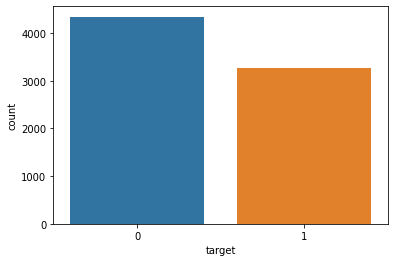

In [42]:
sns.countplot(x=train.target)
print(train.target.value_counts())

In [43]:
y=train.target

## Cleaning the text ##

In [44]:
def clean_text(text):
    #Make text lowercase, remove text in square brackets,remove links,remove punctuation
    #and remove words containing numbers
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('ûªt', '', text)
    text = re.sub('ûª', '', text)
    text = re.sub('ûó', '', text)
    text = re.sub('ûò', '', text)
    text = re.sub('ûï', '', text)
    return text

In [45]:
# train.text = train.text.apply(clean_text)
# test.text = test.text.apply(clean_text)

In [46]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [47]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'û', 'ï']
stop_words = stop_words + more_stopwords

In [48]:
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [49]:
# train.text = train.text.apply(remove_stopwords)
# test.text = test.text.apply(remove_stopwords)

In [50]:
from nltk import SnowballStemmer

In [51]:
stemmer = nltk.SnowballStemmer("english")

In [52]:
def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [53]:
# train.text = train.text.apply(stemm_text)
# test.text = test.text.apply(stemm_text)

In [54]:
def preprocessing(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = stemm_text(text)
    return text

In [55]:
train.text = train.text.apply(preprocessing)
test.text = test.text.apply(preprocessing)

## Creating a dictionary for the text ##

### GloVe Method ###

In [56]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size_2 = 2000

word_tokenizer =  Tokenizer(num_words=vocab_size_2)
word_tokenizer.fit_on_texts(train.text)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

13689

In [57]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [58]:
longest_train = max(train.text, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train.text), 
    length_long_sentence, 
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(test.text), 
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[ 468,  204,   87, ...,    0,    0,    0],
       [ 139,    2,  107, ...,    0,    0,    0],
       [1338,  503, 1805, ...,    0,    0,    0],
       ...,
       [ 449, 1328,    0, ...,    0,    0,    0],
       [  29,  164,  111, ...,    0,    0,    0],
       [ 173,   32,  414, ...,    0,    0,    0]], dtype=int32)

In [59]:
embeddings_dictionary = dict()

# Load GloVe 100D embeddings
with open('./glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [60]:
embed_dim = 100
embedding_matrix = np.zeros((vocab_length, embed_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix.shape

(13689, 100)

### CountVectorizer Method ###

In [61]:
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer

In [62]:
cv = CountVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2)) 
train_vector = cv.fit_transform(train.text)
X_test =cv.transform(test.text)

In [63]:
# tfidf = TfidfVectorizer(max_features=2000, stop_words='english',strip_accents='ascii',analyzer='word')
# train_vector = tfidf.fit_transform(train.text)
# X_test =tfidf.transform(test.text)

In [64]:
# len(tfidf.vocabulary_)

In [65]:
pd.DataFrame.from_dict(cv.vocabulary_, orient='index', columns=['num']).num.sort_values(ascending=False)

zone            999
youtub video    998
youtub          997
youth           996
young           995
               ... 
account           4
accid             3
ablaz             2
abc news          1
abc               0
Name: num, Length: 1000, dtype: int64

In [66]:
train_vector.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0]])

# Train Test Split #

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
X_train, X_valid, y_train, y_valid = train_test_split(train_vector.toarray(), y, test_size=0.2, random_state=42)
X_train_p, X_valid_p, y_train_p, y_valid_p = train_test_split(train_padded_sentences, y, test_size=0.2, random_state=42)
#X_train, X_valid, y_train, y_valid = train_test_split(train.text, y, test_size=0.2, random_state=42)

In [69]:
print([len(X_train), len(y_train)])
print([len(X_valid), len(y_valid)])

[6090, 6090]
[1523, 1523]


## Report of the model ##

In [70]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [71]:
def report(model, X_valid):
    #preds = model.predict(X_valid)
    preds = (model.predict(X_valid) > 0.5).astype('int32')
    print(classification_report(y_valid,preds))
    matrix = confusion_matrix(y_pred=preds, y_true=y_valid,)
    dis = ConfusionMatrixDisplay(confusion_matrix=matrix)
    dis.plot()
    plt.show()

# Model NN (CountVectorizer, GloVe) # 

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, GlobalAveragePooling1D, BatchNormalization, GRU, Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [73]:
[2**i for i in range(0,15)]

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

In [74]:
vocab_size = len(cv.vocabulary_)
embed_dim = 100
rnn_neurons = 128
batch_size = 128

In [75]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0)

In [76]:
model_glove = Sequential()

model_glove.add(Embedding(input_dim=vocab_size_2, output_dim=embed_dim, mask_zero=True))#,batch_input_shape=[batch_size, None]))
model_glove.add(Bidirectional(GRU(128, activation='relu')))
model_glove.add(BatchNormalization(synchronized=True))
model_glove.add(Dense(128, activation='relu',kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)))
model_glove.add(Dropout(0.5))
model_glove.add(Dense(32, activation='relu'))
model_glove.add(Dropout(0.5))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999), loss='binary_crossentropy', metrics=['accuracy']) 

In [77]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True))#,batch_input_shape=[batch_size, None]))
#model.add(Bidirectional(GRU(64, activation='relu')))
model.add(Bidirectional(GRU(128, activation='relu')))
model.add(BatchNormalization(synchronized=True))
#model.add(GlobalAveragePooling1D())
#model.add(Dropout(0.5))
#model.add(Dense(vocab_size, activation='relu'))#,kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)))
#model.add(Dropout(0.5))
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999), loss='binary_crossentropy', metrics=['accuracy']) 

In [78]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         100000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               176640    
 onal)                                                           
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)               

In [79]:
model_glove.fit(X_train_p, y_train_p,
         validation_data=[X_valid_p,y_valid_p],
         epochs=20,
         verbose=1,
         batch_size = 70,
         callbacks=[early_stop])

Epoch 1/20
87/87 [==============================] - 8s 49ms/step - loss: 19.9522 - accuracy: 0.5117 - val_loss: 17.0705 - val_accuracy: 0.5739
Epoch 2/20
87/87 [==============================] - 4s 44ms/step - loss: 14.5633 - accuracy: 0.6238 - val_loss: 12.2108 - val_accuracy: 0.5739
Epoch 3/20
87/87 [==============================] - 4s 43ms/step - loss: 10.1462 - accuracy: 0.7069 - val_loss: 8.2832 - val_accuracy: 0.5923
Epoch 4/20
87/87 [==============================] - 4s 41ms/step - loss: 6.5922 - accuracy: 0.7773 - val_loss: 5.1856 - val_accuracy: 0.7800
Epoch 5/20
87/87 [==============================] - 4s 41ms/step - loss: 3.8910 - accuracy: 0.8176 - val_loss: 2.9035 - val_accuracy: 0.8056
Epoch 6/20
87/87 [==============================] - 4s 41ms/step - loss: 2.0221 - accuracy: 0.8438 - val_loss: 1.4261 - val_accuracy: 0.8070
Epoch 7/20
87/87 [==============================] - 3s 40ms/step - loss: 0.9161 - accuracy: 0.8604 - val_loss: 0.6833 - val_accuracy: 0.7997
Epoch 8/

In [80]:
model.fit(X_train, y_train,
         validation_data=[X_valid,y_valid],
         epochs=10,
         verbose=1,
         batch_size = 70,
         callbacks=[early_stop])

Epoch 1/10
87/87 [==============================] - 149s 2s/step - loss: 19.7952 - accuracy: 0.5593 - val_loss: 16.9183 - val_accuracy: 0.5739
Epoch 2/10
87/87 [==============================] - 139s 2s/step - loss: 14.4153 - accuracy: 0.5882 - val_loss: 12.0537 - val_accuracy: 0.5739
Epoch 3/10
87/87 [==============================] - 140s 2s/step - loss: 10.0295 - accuracy: 0.5920 - val_loss: 8.1408 - val_accuracy: 0.5739
Epoch 4/10
87/87 [==============================] - 134s 2s/step - loss: 6.5659 - accuracy: 0.5975 - val_loss: 5.1210 - val_accuracy: 0.5739
Epoch 5/10
87/87 [==============================] - 137s 2s/step - loss: 3.9625 - accuracy: 0.5997 - val_loss: 2.9351 - val_accuracy: 0.5758
Epoch 6/10
87/87 [==============================] - 131s 2s/step - loss: 2.1628 - accuracy: 0.6010 - val_loss: 1.5129 - val_accuracy: 0.5982
Epoch 7/10
87/87 [==============================] - 134s 2s/step - loss: 1.1011 - accuracy: 0.6013 - val_loss: 0.7998 - val_accuracy: 0.6225
Epoch 8/

<AxesSubplot:>

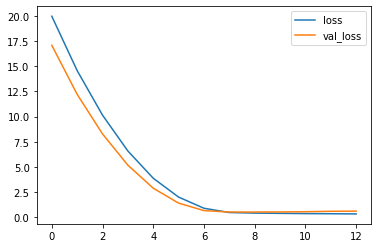

In [81]:
pd.DataFrame(model_glove.history.history)[['loss','val_loss']].plot()

<AxesSubplot:>

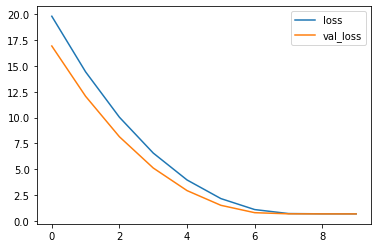

In [82]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

48/48 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       874
           1       0.73      0.72      0.73       649

    accuracy                           0.77      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



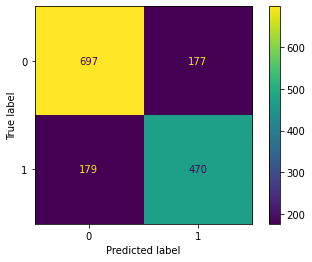

In [83]:
report(model_glove, X_valid_p)

48/48 [==============================] - 8s 162ms/step
              precision    recall  f1-score   support

           0       0.63      0.84      0.72       874
           1       0.62      0.35      0.44       649

    accuracy                           0.63      1523
   macro avg       0.63      0.59      0.58      1523
weighted avg       0.63      0.63      0.60      1523



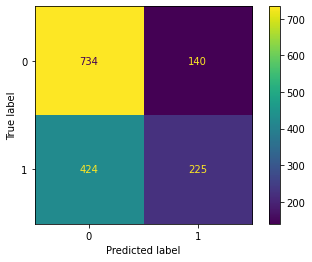

In [84]:
report(model, X_valid)

In [85]:
prediction_glove = (model_glove.predict(test_padded_sentences) > 0.5).astype('int32')

102/102 [==============================] - 1s 5ms/step


In [86]:
submission = pd.DataFrame(data=prediction_glove, index=test.index, columns=['target'])

In [87]:
submission.to_csv('submission.csv')

# Model Naive Bayes Classification #

In [99]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB()

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       874
           1       0.79      0.69      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



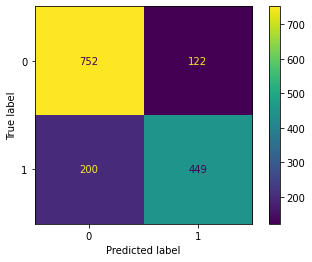

In [100]:
report(nb, X_valid)

In [90]:
prediction_nb = nb.predict(X_test)

# Model Random Forest #

In [91]:
from sklearn.ensemble import RandomForestClassifier

In [92]:
RFmodel = RandomForestClassifier()

In [93]:
RFmodel=RandomForestClassifier(n_estimators=200, max_features='sqrt',criterion='gini')
RFmodel.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       874
           1       0.72      0.69      0.71       649

    accuracy                           0.75      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.75      0.75      0.75      1523



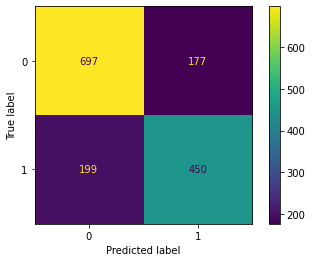

In [94]:
report(RFmodel, X_valid)

In [95]:
prediction_RF_result = RFmodel.predict(X_test)

In [96]:
pd.DataFrame(data=prediction_RF_result, index=test.index, columns=['target'])

,target
id,
0,1
2,1
3,0
9,1
11,1
...,...
10861,1
10865,0
10868,1
